**Downgrade Keras and import necessary libraries:**


In [0]:
!pip uninstall keras -y
!pip install keras==2.1.6

Uninstalling Keras-2.2.4:
  Successfully uninstalled Keras-2.2.4
     |████████████████████████████████| 348kB 9.5MB/s 


In [0]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K

#fr_utils imports

from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import h5py
import matplotlib.pyplot as plt

#inception_blocks_v2 imports

from keras.layers.core import Lambda, Flatten, Dense

Using TensorFlow backend.


**Define classes and functions for face recognition**

In [0]:
#################### fr_utils.py ############

class Fr_Utils:
    _FLOATX = 'float32'

    def variable(self, value, dtype=_FLOATX, name=None):
        v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
        _get_session().run(v.initializer)
        return v

    def shape(self, x):
        return x.get_shape()

    def square(self, x):
        return tf.square(x)

    def zeros(self, shape, dtype=_FLOATX, name=None):
        return variable(np.zeros(shape), dtype, name)

    def concatenate(self, tensors, axis=-1):
        if axis < 0:
            axis = axis % len(tensors[0].get_shape())
        return tf.concat(axis, tensors)

    def LRN2D(self, x):
        return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

    def conv2d_bn(x,
                  layer=None,
                  cv1_out=None,
                  cv1_filter=(1, 1),
                  cv1_strides=(1, 1),
                  cv2_out=None,
                  cv2_filter=(3, 3),
                  cv2_strides=(1, 1),
                  padding=None):
        num = '' if cv2_out == None else '1'
        tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
        tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
        tensor = Activation('relu')(tensor)
        if padding == None:
            return tensor
        tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
        if cv2_out == None:
            return tensor
        tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
        tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
        tensor = Activation('relu')(tensor)
        return tensor

    WEIGHTS = [
      'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
      'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
      'inception_3a_pool_conv', 'inception_3a_pool_bn',
      'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
      'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
      'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
      'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
      'inception_3b_pool_conv', 'inception_3b_pool_bn',
      'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
      'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
      'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
      'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
      'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
      'inception_4a_pool_conv', 'inception_4a_pool_bn',
      'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
      'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
      'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
      'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
      'inception_5a_pool_conv', 'inception_5a_pool_bn',
      'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
      'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
      'inception_5b_pool_conv', 'inception_5b_pool_bn',
      'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
      'dense_layer'
    ]

    conv_shape = {
      'conv1': [64, 3, 7, 7],
      'conv2': [64, 64, 1, 1],
      'conv3': [192, 64, 3, 3],
      'inception_3a_1x1_conv': [64, 192, 1, 1],
      'inception_3a_pool_conv': [32, 192, 1, 1],
      'inception_3a_5x5_conv1': [16, 192, 1, 1],
      'inception_3a_5x5_conv2': [32, 16, 5, 5],
      'inception_3a_3x3_conv1': [96, 192, 1, 1],
      'inception_3a_3x3_conv2': [128, 96, 3, 3],
      'inception_3b_3x3_conv1': [96, 256, 1, 1],
      'inception_3b_3x3_conv2': [128, 96, 3, 3],
      'inception_3b_5x5_conv1': [32, 256, 1, 1],
      'inception_3b_5x5_conv2': [64, 32, 5, 5],
      'inception_3b_pool_conv': [64, 256, 1, 1],
      'inception_3b_1x1_conv': [64, 256, 1, 1],
      'inception_3c_3x3_conv1': [128, 320, 1, 1],
      'inception_3c_3x3_conv2': [256, 128, 3, 3],
      'inception_3c_5x5_conv1': [32, 320, 1, 1],
      'inception_3c_5x5_conv2': [64, 32, 5, 5],
      'inception_4a_3x3_conv1': [96, 640, 1, 1],
      'inception_4a_3x3_conv2': [192, 96, 3, 3],
      'inception_4a_5x5_conv1': [32, 640, 1, 1,],
      'inception_4a_5x5_conv2': [64, 32, 5, 5],
      'inception_4a_pool_conv': [128, 640, 1, 1],
      'inception_4a_1x1_conv': [256, 640, 1, 1],
      'inception_4e_3x3_conv1': [160, 640, 1, 1],
      'inception_4e_3x3_conv2': [256, 160, 3, 3],
      'inception_4e_5x5_conv1': [64, 640, 1, 1],
      'inception_4e_5x5_conv2': [128, 64, 5, 5],
      'inception_5a_3x3_conv1': [96, 1024, 1, 1],
      'inception_5a_3x3_conv2': [384, 96, 3, 3],
      'inception_5a_pool_conv': [96, 1024, 1, 1],
      'inception_5a_1x1_conv': [256, 1024, 1, 1],
      'inception_5b_3x3_conv1': [96, 736, 1, 1],
      'inception_5b_3x3_conv2': [384, 96, 3, 3],
      'inception_5b_pool_conv': [96, 736, 1, 1],
      'inception_5b_1x1_conv': [256, 736, 1, 1],
    }

    global load_weights_from_FaceNet
    def load_weights_from_FaceNet(FRmodel):
        # Load weights from csv files (which was exported from Openface torch model)
        weights = Fr_Utils.WEIGHTS
        weights_dict = Fr_Utils.load_weights()

        # Set layer weights of the model
        for name in weights:
            if FRmodel.get_layer(name) != None:
                FRmodel.get_layer(name).set_weights(weights_dict[name])
            elif model.get_layer(name) != None:
                model.get_layer(name).set_weights(weights_dict[name])

    def load_weights():
        # Set weights path
        dirPath = './weights'
        fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
        paths = {}
        weights_dict = {}

        for n in fileNames:
            paths[n.replace('.csv', '')] = dirPath + '/' + n

        for name in Fr_Utils.WEIGHTS:
            if 'conv' in name:
                conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
                conv_w = np.reshape(conv_w, Fr_Utils.conv_shape[name])
                conv_w = np.transpose(conv_w, (2, 3, 1, 0))
                conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
                weights_dict[name] = [conv_w, conv_b]     
            elif 'bn' in name:
                bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
                bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
                bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
                bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
                weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
            elif 'dense' in name:
                dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
                dense_w = np.reshape(dense_w, (128, 736))
                dense_w = np.transpose(dense_w, (1, 0))
                dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
                weights_dict[name] = [dense_w, dense_b]

        return weights_dict
      
    def select_main_face(faces):
        main_face = []
        square = 0
        for face in faces:
          face_sq = face[2]*face[3]
          if (face_sq > square):
            square = face_sq
            main_face = face

        return main_face

    global img_path_to_encoding
    def img_path_to_encoding(image_path, model, padding = 0.25):
        face = detect_face(image_path, padding)
        return img_to_encoding(face, model)

    global img_to_encoding
    def img_to_encoding(image, model):
        image = cv2.resize(image, (96, 96)) 
        img = image[...,::-1]
        img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
        x_train = np.array([img])
        embedding = model.predict_on_batch(x_train)
        return embedding

    global detect_face
    def detect_face(image_path, padding = 0.25):
        if not os.path.isfile(image_path):
            raise Exception('No such file in directory')
        img = cv2.imread(image_path,1)
        facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = facecascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
        face = Fr_Utils.select_main_face(faces)
        if (len(face)<4):
            raise Exception('No faces detected')
        x,y,w,h = face[0], face[1], face[2], face[3]        
        if (0 < padding < 1):
            padding = int(padding*(w+h)/2)
        x,y,w,h = x - padding, y - padding, w + 2*padding, h + 2*padding 
        face_detect = img[max(0,y):min(img.shape[0],y+h),max(0,x):min(img.shape[1], x+w)]
        return face_detect

In [0]:
######################## inception_blocks_v2.py ######################

class Inception_Blocks:
    
    global inception_block_1a
    def inception_block_1a(X):
        """
        Implementation of an inception block
        """

        X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
        X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
        X_3x3 = Activation('relu')(X_3x3)
        X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
        X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
        X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
        X_3x3 = Activation('relu')(X_3x3)

        X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
        X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
        X_5x5 = Activation('relu')(X_5x5)
        X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
        X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
        X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
        X_5x5 = Activation('relu')(X_5x5)

        X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
        X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
        X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
        X_pool = Activation('relu')(X_pool)
        X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

        X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
        X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
        X_1x1 = Activation('relu')(X_1x1)

        # CONCAT
        inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

        return inception

    global inception_block_1b
    def inception_block_1b(X):
        X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
        X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
        X_3x3 = Activation('relu')(X_3x3)
        X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
        X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
        X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
        X_3x3 = Activation('relu')(X_3x3)

        X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
        X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
        X_5x5 = Activation('relu')(X_5x5)
        X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
        X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
        X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
        X_5x5 = Activation('relu')(X_5x5)

        X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
        X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
        X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
        X_pool = Activation('relu')(X_pool)
        X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

        X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
        X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
        X_1x1 = Activation('relu')(X_1x1)

        inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

        return inception

    global inception_block_1c
    def inception_block_1c(X):
        X_3x3 = Fr_Utils.conv2d_bn(X,
                               layer='inception_3c_3x3',
                               cv1_out=128,
                               cv1_filter=(1, 1),
                               cv2_out=256,
                               cv2_filter=(3, 3),
                               cv2_strides=(2, 2),
                               padding=(1, 1))

        X_5x5 = Fr_Utils.conv2d_bn(X,
                               layer='inception_3c_5x5',
                               cv1_out=32,
                               cv1_filter=(1, 1),
                               cv2_out=64,
                               cv2_filter=(5, 5),
                               cv2_strides=(2, 2),
                               padding=(2, 2))

        X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
        X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

        inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

        return inception

    global inception_block_2a
    def inception_block_2a(X):
        X_3x3 = Fr_Utils.conv2d_bn(X,
                               layer='inception_4a_3x3',
                               cv1_out=96,
                               cv1_filter=(1, 1),
                               cv2_out=192,
                               cv2_filter=(3, 3),
                               cv2_strides=(1, 1),
                               padding=(1, 1))
        X_5x5 = Fr_Utils.conv2d_bn(X,
                               layer='inception_4a_5x5',
                               cv1_out=32,
                               cv1_filter=(1, 1),
                               cv2_out=64,
                               cv2_filter=(5, 5),
                               cv2_strides=(1, 1),
                               padding=(2, 2))

        X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
        X_pool = Fr_Utils.conv2d_bn(X_pool,
                               layer='inception_4a_pool',
                               cv1_out=128,
                               cv1_filter=(1, 1),
                               padding=(2, 2))
        X_1x1 = Fr_Utils.conv2d_bn(X,
                               layer='inception_4a_1x1',
                               cv1_out=256,
                               cv1_filter=(1, 1))
        inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

        return inception

    global inception_block_2b
    def inception_block_2b(X):
        #inception4e
        X_3x3 = Fr_Utils.conv2d_bn(X,
                               layer='inception_4e_3x3',
                               cv1_out=160,
                               cv1_filter=(1, 1),
                               cv2_out=256,
                               cv2_filter=(3, 3),
                               cv2_strides=(2, 2),
                               padding=(1, 1))
        X_5x5 = Fr_Utils.conv2d_bn(X,
                               layer='inception_4e_5x5',
                               cv1_out=64,
                               cv1_filter=(1, 1),
                               cv2_out=128,
                               cv2_filter=(5, 5),
                               cv2_strides=(2, 2),
                               padding=(2, 2))

        X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
        X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

        inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

        return inception
      
    global inception_block_3a
    def inception_block_3a(X):
        X_3x3 = Fr_Utils.conv2d_bn(X,
                               layer='inception_5a_3x3',
                               cv1_out=96,
                               cv1_filter=(1, 1),
                               cv2_out=384,
                               cv2_filter=(3, 3),
                               cv2_strides=(1, 1),
                               padding=(1, 1))
        X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
        X_pool = Fr_Utils.conv2d_bn(X_pool,
                               layer='inception_5a_pool',
                               cv1_out=96,
                               cv1_filter=(1, 1),
                               padding=(1, 1))
        X_1x1 = Fr_Utils.conv2d_bn(X,
                               layer='inception_5a_1x1',
                               cv1_out=256,
                               cv1_filter=(1, 1))

        inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

        return inception

    global inception_block_3b
    def inception_block_3b(X):
        X_3x3 = Fr_Utils.conv2d_bn(X,
                               layer='inception_5b_3x3',
                               cv1_out=96,
                               cv1_filter=(1, 1),
                               cv2_out=384,
                               cv2_filter=(3, 3),
                               cv2_strides=(1, 1),
                               padding=(1, 1))
        X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
        X_pool = Fr_Utils.conv2d_bn(X_pool,
                               layer='inception_5b_pool',
                               cv1_out=96,
                               cv1_filter=(1, 1))
        X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

        X_1x1 = Fr_Utils.conv2d_bn(X,
                               layer='inception_5b_1x1',
                               cv1_out=256,
                               cv1_filter=(1, 1))
        inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

        return inception

    global faceRecoModel
    def faceRecoModel(input_shape):
        """
        Implementation of the Inception model used for FaceNet

        Arguments:
        input_shape -- shape of the images of the dataset
        Returns:
        model -- a Model() instance in Keras
        """

        # Define the input as a tensor with shape input_shape
        X_input = Input(input_shape)

        # Zero-Padding
        X = ZeroPadding2D((3, 3))(X_input)

        # First Block
        X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
        X = BatchNormalization(axis = 1, name = 'bn1')(X)
        X = Activation('relu')(X)

        # Zero-Padding + MAXPOOL
        X = ZeroPadding2D((1, 1))(X)
        X = MaxPooling2D((3, 3), strides = 2)(X)

        # Second Block
        X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
        X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
        X = Activation('relu')(X)

        # Zero-Padding + MAXPOOL
        X = ZeroPadding2D((1, 1))(X)

        # Second Block
        X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
        X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
        X = Activation('relu')(X)

        # Zero-Padding + MAXPOOL
        X = ZeroPadding2D((1, 1))(X)
        X = MaxPooling2D(pool_size = 3, strides = 2)(X)

        # Inception 1: a/b/c
        X = inception_block_1a(X)
        X = inception_block_1b(X)
        X = inception_block_1c(X)

        # Inception 2: a/b
        X = inception_block_2a(X)
        X = inception_block_2b(X)

        # Inception 3: a/b
        X = inception_block_3a(X)
        X = inception_block_3b(X)

        # Top layer
        X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
        X = Flatten()(X)
        X = Dense(128, name='dense_layer')(X)

        # L2 normalization
        X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

        # Create model instance
        model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')

        return model

In [0]:
def prepare_database(padding = 0.25):
  database = {}

  # load all the images of individuals to recognize into the database
  for file in glob.glob("images/*"):
    identity = os.path.splitext(os.path.basename(file))[0]
    database[identity] = img_path_to_encoding(file, FRmodel, padding)

  return database

In [0]:
def who_is_it(image, database, model, padding = 0.25):
    face = detect_face(image, padding)
    encoding = img_to_encoding(face, model)
    
    min_dist = 100
    identity = None
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(db_enc - encoding)

        print('distance for %s is %s' %(name, dist))

        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.52:
        return None
    else:
        return identity

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.3):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,
               positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, 
               negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))

    return loss

**Load images and weights** 
 > To load weights.zip and xml for opencv - click upload on Files tab 
 
 > To load images - click upload on 'images' folder

In [0]:
#os.mkdir('images')
!unzip weights.zip
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/levin.jpg        
  inflating: images/mark.jpg         
  inflating: images/putin.jpg        
  inflating: images/radcliffe.jpg    
  inflating: images/smith.jpg        


**Test launch**

In [0]:
## Build a model from weights

K.set_image_data_format('channels_first')

FRmodel = faceRecoModel(input_shape=(3, 96, 96))

FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
## Save pictures from 'images' folder to database

database = prepare_database(0.25)

In [110]:
## Upload a picture to current folder (/content) and proceed the recognition
img = 'test17.jpg'
res = who_is_it(img, database, FRmodel, 0.25)

distance for putin is 0.7731235
distance for levin is 0.42201132
distance for mark is 1.0916669
distance for radcliffe is 0.8751313
distance for smith is 0.5499275


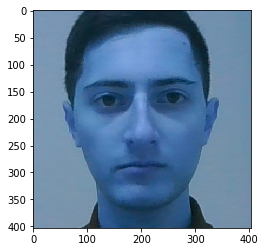

In [111]:
img1 = detect_face(img,0.1)
plt.imshow(img1)

Current user is levin


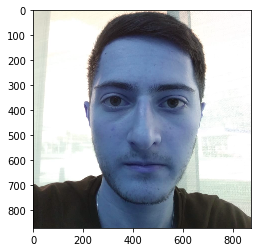

In [112]:
if (res != None):
    print('Current user is ' + res)
    img2 = detect_face('images/'+ res + '.jpg',0.25)
    plt.imshow(img2)

In [0]:
import shutil

shutil.rmtree('images')